# HA3 "Recommender System" take 08

## Setup

In [1]:
import numpy as np
import pandas as pd

from random import randrange

import matplotlib.pyplot as plt

## Load Data

In [2]:
file_path = "../../data/assignment_03/"

baskets_pq = "baskets.parquet"
coupons_pq = "coupons.parquet"
prediction_index_pq = "prediction_index.parquet"

b_df = pd.read_parquet(file_path + baskets_pq)
c_df = pd.read_parquet(file_path + coupons_pq)
pi_df = pd.read_parquet(file_path + prediction_index_pq)

print(f"baskets_df: {b_df.shape}")
print(f"coupons_df: {c_df.shape}")
print(f"prediction_index_df: {pi_df.shape}")

baskets_df: (68841598, 4)
coupons_df: (45000000, 4)
prediction_index_df: (500000, 3)


## Data Preprocessing

### A. Shoppers Targetting

In [3]:
num_of_shoppers = 100

shoppers = [randrange(0, 2000) for i in range(num_of_shoppers)]
# shoppers = [i for i in range(num_of_shoppers)]
# shoppers

### B. Original Prices

In [4]:
orig_price = b_df.groupby(["product"])["price"].agg(["max"]).reset_index()
print(f"orig_price.shape: {orig_price.shape}")
orig_price.head(2)

orig_price.shape: (250, 2)


,product,max
0,0,688
1,1,560


### C. Generate master dataframe with selected shoppers

In [5]:
def gen_complete_week_prod_df_for_shoppers(list_shoppers, orig_df):
    products = np.array([p for p in range(250)])
    orig_price_list = orig_df["max"].values
    
    weeks = [i for i in range(90)]
    
    product_price_pair = np.stack((products, orig_price_list), axis=0).T
    
    prod_in_weeks = []
    for w in weeks:
        for p in product_price_pair:
            prod_in_weeks.append([w, *p])
    
    df_template = pd.DataFrame(data=prod_in_weeks, columns=["week", "product", "orig_price"])
    
    df_master = None;
    
    for idx, shoppers in enumerate(list_shoppers):

        df_local = df_template.copy()
        df_local["shopper"] = shoppers
        
        if idx == 0:
            df_master = df_local
        else:
            # stack it
            df_master = pd.concat([df_master, df_local], axis=0)
    return df_master

In [6]:
df = gen_complete_week_prod_df_for_shoppers(shoppers, orig_price)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (2250000, 4)


,week,product,orig_price,shopper
0,0,0,688,1104
1,0,1,560,1104
2,0,2,773,1104


### D. Target Column added

In [7]:
b_df["target"] = 1
df = pd.merge(df, b_df, how="left", on=["week", "shopper", "product"])
df["target"] = df["target"].fillna(0)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (2250000, 6)


,week,product,orig_price,shopper,price,target
0,0,0,688,1104,NaN,0.0
1,0,1,560,1104,NaN,0.0
2,0,2,773,1104,NaN,0.0


### E. Discount Given Column added

In [8]:
c_df["coupon_given"] = 1
df = df.merge(right=c_df, how="left", on=["week", "shopper", "product"])
df["discount"] = df["discount"].fillna(0)
df["coupon_given"] = df["coupon_given"].fillna(0)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (2250000, 8)


,week,product,orig_price,shopper,price,target,discount,coupon_given
0,0,0,688,1104,NaN,0.0,0.0,0.0
1,0,1,560,1104,NaN,0.0,0.0,0.0
2,0,2,773,1104,NaN,0.0,0.0,0.0


### F. Price with discount

In [9]:
df["price_w_discount"] = df["orig_price"] - df["discount"]
df.head(3)

,week,product,orig_price,shopper,price,target,discount,coupon_given,price_w_discount
0,0,0,688,1104,NaN,0.0,0.0,0.0,688.0
1,0,1,560,1104,NaN,0.0,0.0,0.0,560.0
2,0,2,773,1104,NaN,0.0,0.0,0.0,773.0


In [10]:
# price column is no longer necessary so removing it
df = df.drop(columns=["price"])
df.head(3)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount
0,0,0,688,1104,0.0,0.0,0.0,688.0
1,0,1,560,1104,0.0,0.0,0.0,560.0
2,0,2,773,1104,0.0,0.0,0.0,773.0


## Split Data Before Feature Engineering

In [11]:
# Train: 0 - 88
# Test: 88 - 89
cut_day = 89

# Separate train and test
train = df[df["week"] < cut_day]
test = df[df["week"] >= cut_day]

b_train = b_df[b_df["week"] < cut_day]
b_test = b_df[b_df["week"] >= cut_day]

c_train = c_df[c_df["week"] < cut_day]
c_test = c_df[c_df["week"] >= cut_day]

print(f"Master: {df.shape}, Train: {train.shape}, Test: {test.shape}")

Master: (2250000, 8), Train: (2225000, 8), Test: (25000, 8)


## Feature Engineering

### A. Average Bakset Size per Shopper per week - Shopper's Perspective

In [12]:
num_prod_per_week_per_shopper = b_train.groupby(["shopper", "week"], as_index=False)["product"].count()
num_prod_per_week_per_shopper = num_prod_per_week_per_shopper.rename({"product": "avg_basket_size"}, axis=1)
avg_baskets = num_prod_per_week_per_shopper.groupby(["shopper"], as_index=False)["avg_basket_size"].mean()

In [13]:
# Merge to shoppers on train and test

train = train.merge(avg_baskets, how="left", on="shopper")
test = test.merge(avg_baskets, how="left", on="shopper")

In [14]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size
0,0,0,688,1104,0.0,0.0,0.0,688.0,7.797753
1,0,1,560,1104,0.0,0.0,0.0,560.0,7.797753


### B. Average Price per Shopper per Week - Shopper's Perspective

- How much on average did a shopper spend a week?

In [15]:
avg_price_per_shopper_per_week = b_train.groupby(["shopper"], as_index=False)["price"].mean()

In [16]:
# Include it to the shoppers

train = train.merge(avg_price_per_shopper_per_week, how="left", on="shopper")
test = test.merge(avg_price_per_shopper_per_week, how="left", on="shopper")

In [17]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price
0,0,0,688,1104,0.0,0.0,0.0,688.0,7.797753,597.842939
1,0,1,560,1104,0.0,0.0,0.0,560.0,7.797753,597.842939


### C. Number of Unique Products purchased per Shopper - Shopper's Perspective

In [18]:
num_unique_prods_per_shopper = b_train.groupby(["shopper"], as_index=False)["product"].nunique()
num_unique_prods_per_shopper = num_unique_prods_per_shopper.rename({ "product": "num_unique_prods"}, axis=1)

In [19]:
# Include it to the shoppers

train = train.merge(num_unique_prods_per_shopper, how="left", on="shopper")
test = test.merge(num_unique_prods_per_shopper, how="left", on="shopper")

### D. Number of times products have been reordered - Product's perspective on Shoppers

In [20]:
# copy product column
num_reordered = b_train.copy()
num_reordered["num_reordered"] = num_reordered["product"]
num_reordered = num_reordered.groupby(["shopper", "product", "num_reordered"], as_index=False)["num_reordered"].count()
# num_reordered

In [21]:
# Merge to train and test
train = train.merge(num_reordered, how="left", on=["shopper","product"])
test = test.merge(num_reordered, how="left", on=["shopper","product"])

In [22]:
train["num_reordered"] = train["num_reordered"].fillna(0)
test["num_reordered"] = test["num_reordered"].fillna(0)

### E. Weeks Since Prior Order

#### a. train

In [23]:
# Train set
addkey = train.groupby(['shopper','product'])["target"].apply(lambda x : x.eq(1).shift().fillna(0).cumsum())
train['weeks_since_prior_order'] = train["target"].eq(0).groupby([train['shopper'], train['product'], addkey]).cumcount().add(1) # .cumsum()

In [24]:
train.sample(5)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order
865435,79,185,541,590,0.0,0.0,0.0,541.0,8.247191,577.757493,66,0.0,80
637340,57,90,549,332,0.0,0.0,0.0,549.0,8.089888,589.665278,96,0.0,58
1157869,3,119,532,811,0.0,0.0,0.0,532.0,6.123596,580.328440,63,0.0,4
586484,31,234,456,1572,0.0,0.0,0.0,456.0,6.752809,569.931780,58,1.0,32
1921181,30,181,493,1041,0.0,0.0,0.0,493.0,8.415730,614.093458,81,0.0,31


#### b. test

In [25]:
# Test set
last_weeks_since_prior_order = train.groupby(['shopper', 'product']).weeks_since_prior_order.last() + 1

In [26]:
test = test.merge(last_weeks_since_prior_order, on=['shopper', 'product'])

### F. Category

#### f - 1. gensim Word2Vec

In [27]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [28]:
# Caution ! Takes REAALLY Long !!
# TEMPORARY - Since target shopper is limited to 2000, reduce the basket to 2000

# by basket => groupby(["week", "shopper"])

num_shoppers = 5000

by_basket_str = b_df[b_df["shopper"] < num_shoppers]
by_basket_str["product"] = by_basket_str["product"].astype(str)
by_basket_str = by_basket_str.groupby(["week", "shopper"])["product"].apply(list).reset_index(name="list_prod")

<ipython-input-28-b470deef2cb6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  by_basket_str["product"] = by_basket_str["product"].astype(str)


In [29]:
by_basket_str.head()

,week,shopper,list_prod
0,0,0,"[71, 91, 116, 123, 157, 167, 171, 184, 207, 225]"
1,0,1,"[22, 35, 92, 146, 168, 200, 211, 229]"
2,0,2,"[14, 121, 164, 218, 230, 249]"
3,0,3,"[6, 67, 98, 137, 145, 192, 222]"
4,0,4,"[25, 76, 156, 188, 234]"


In [30]:
by_basket = by_basket_str["list_prod"].tolist()

In [31]:
# Create a Word2Vec model
w2v_model = Word2Vec(
    sentences=by_basket,
    min_count=10,
    negative=5,
    sample=0,
    sg=1,
    workers=10,
)

# summarize the loaded model
print(w2v_model)

Word2Vec(vocab=250, size=100, alpha=0.025)


In [32]:
# Summarize vocabulary
words = list(w2v_model.wv.vocab)
print("Words Length: {}".format(len(words)))
print(words[0:10])

Words Length: 250
['71', '91', '116', '123', '157', '167', '171', '184', '207', '225']


In [33]:
# Product vector for 76

# Most similar to a sample product 76
print(w2v_model.wv.most_similar(positive='76'))
print(f"Product Vector size: {len(w2v_model['76'])}")
print(w2v_model["76"])

[('74', 0.6760458946228027), ('71', 0.6676470041275024), ('79', 0.6443140506744385), ('72', 0.6296259760856628), ('73', 0.6281592845916748), ('78', 0.6244284510612488), ('75', 0.6129441857337952), ('77', 0.5983553528785706), ('70', 0.5030338764190674), ('4', 0.28962719440460205)]
Product Vector size: 100
[-4.49244022e-01  9.97306686e-03  2.50140578e-02 -2.03035012e-01
 -1.32893711e-01  1.85158998e-02 -4.33086574e-01 -6.13075197e-01
 -2.15376049e-01 -8.98842327e-03 -3.89670730e-02 -3.13917957e-02
 -6.07176423e-02 -3.02777976e-01 -7.64972195e-02  5.09481370e-01
 -2.29339629e-01 -1.43286571e-01  4.71261851e-02 -2.90716469e-01
  2.09645629e-01  5.09737670e-01 -2.71235168e-01  3.26186381e-02
  7.53157884e-02 -1.36387661e-01 -2.37643614e-01 -1.21975492e-03
  1.86619386e-01  9.81405824e-02 -2.00293317e-01  4.34978269e-02
 -2.50853121e-01  1.57074049e-01 -2.35967696e-01 -3.13234746e-01
 -1.90181136e-02  3.30818325e-01  4.14373316e-02  2.55834192e-01
  7.01626539e-01  1.44468313e-02  6.81848614

<ipython-input-33-aff2342eceae>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(f"Product Vector size: {len(w2v_model['76'])}")
<ipython-input-33-aff2342eceae>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(w2v_model["76"])


#### f - 2. t-SNE

In [34]:
X = w2v_model[w2v_model.wv.vocab]
print(X.shape)
X

(250, 100)


<ipython-input-34-a34c8899bf7e>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = w2v_model[w2v_model.wv.vocab]


array([[-0.34244356, -0.05760932,  0.24777894, ...,  0.16187362,
        -0.27812737,  0.1638071 ],
       [ 0.05904718,  0.04692873, -0.242651  , ...,  0.31054577,
        -0.15847665,  0.07221832],
       [-0.11699706,  0.04748468, -0.08091777, ..., -0.0894508 ,
         0.98365635, -0.5059344 ],
       ...,
       [-0.23771392,  0.645384  ,  0.46345192, ..., -0.06572494,
         0.0599285 , -0.20345847],
       [ 0.4479573 ,  0.3027231 ,  0.66288567, ...,  0.23501475,
         0.11038926,  0.16647281],
       [ 0.18279634,  0.2683801 ,  0.32180232, ...,  0.48424897,
        -0.63083535,  0.24094461]], dtype=float32)

In [35]:
N = 1000

config_tsne = {
    "n_components": 2,
    "init": "pca",
    "random_state": 0,
    "n_iter": 1_000,
}

In [36]:
tsne = TSNE(**config_tsne)
Y_tsne = tsne.fit_transform(X)

In [37]:
Y_tsne[0:10]

array([[  1.1582096 ,  12.488287  ],
       [ -0.8076913 ,   1.7598119 ],
       [  1.4009496 ,  -2.5836122 ],
       [ -2.5221133 ,   7.001284  ],
       [  7.4291296 ,  -2.2307496 ],
       [  2.5239587 ,   6.602171  ],
       [  9.496319  ,   1.7846711 ],
       [ -0.37547067,  -7.240789  ],
       [-12.406553  ,  -5.366438  ],
       [ 13.734221  ,   6.020823  ]], dtype=float32)

In [38]:
# kl_divergence - What does this indicate ?
tsne.kl_divergence_

0.418730229139328

In [39]:
# Learning rate
tsne.learning_rate

200.0

In [40]:
# Method
tsne.method

'barnes_hut'

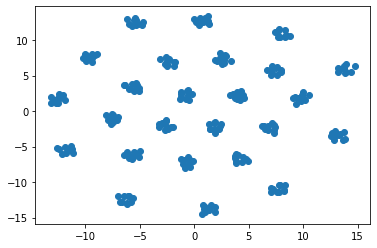

In [41]:
# We see 25 clusters
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], cmap=plt.cm.Spectral)
plt.show()

In [42]:
# kMeans
from sklearn.cluster import KMeans

In [43]:
Y_tsne[0:10]

array([[  1.1582096 ,  12.488287  ],
       [ -0.8076913 ,   1.7598119 ],
       [  1.4009496 ,  -2.5836122 ],
       [ -2.5221133 ,   7.001284  ],
       [  7.4291296 ,  -2.2307496 ],
       [  2.5239587 ,   6.602171  ],
       [  9.496319  ,   1.7846711 ],
       [ -0.37547067,  -7.240789  ],
       [-12.406553  ,  -5.366438  ],
       [ 13.734221  ,   6.020823  ]], dtype=float32)

In [44]:
kmeans = KMeans(n_clusters=25, random_state=0).fit(Y_tsne)
kmeans.labels_

array([19,  1, 24, 15, 14, 11,  2,  5,  0, 17,  3,  9,  1, 21, 11,  0,  6,
       17, 10, 15, 11,  6, 20, 13, 12,  7,  1, 22, 21,  4, 17,  3, 19, 14,
        5, 20, 23, 21, 17, 13, 10,  8, 24, 21,  4, 20,  7, 19,  8, 24, 14,
        5,  4,  3,  9, 19, 23, 21, 14,  4, 17, 18,  7,  0, 19,  8, 15, 12,
        7,  1,  8, 24, 22,  5, 13, 12, 21, 11,  1, 24, 22, 14,  5,  4, 18,
       19,  0, 13,  3, 24, 13, 18,  8,  4, 12,  6, 10,  9,  1,  8,  2,  0,
       15,  4,  6, 13, 16,  7, 15, 22, 17, 20,  9, 23, 11, 23, 14, 18, 18,
        7,  5,  6, 12, 18, 16,  5,  4, 10, 21, 14, 15,  3, 18,  0, 18, 15,
        9, 23, 14, 11,  2,  5, 17,  9, 18, 19, 23,  1, 11, 10,  3, 19, 22,
        9,  7, 24, 12,  4, 20,  3, 18, 15,  7,  4, 17,  9, 13, 10,  9, 12,
       21, 14, 10, 21,  2, 16, 10,  0,  6, 16, 20,  3, 24, 24, 10, 17,  0,
       21,  6, 13, 16,  8, 20,  7, 19,  1, 22,  2, 22,  7, 22, 12, 11,  2,
        6, 15,  3,  8, 23,  5, 13, 11,  0, 14, 12,  1,  2,  8,  1, 24,  3,
       23,  8,  6,  5,  2

In [45]:
# Generate a product category
products = [product for product in range(250)]
prods_cat_table = pd.DataFrame(data=products, columns=["product"])
prods_cat_table["category"] = kmeans.labels_
prods_cat_table.head()

,product,category
0,0,19
1,1,1
2,2,24
3,3,15
4,4,14


In [46]:
train = train.merge(right=prods_cat_table, how="left", on=["product"])
test = test.merge(right=prods_cat_table, how="left", on=["product"])

In [47]:
train[(train["shopper"] == 0) & (train["target"] == 1) & (train["product"] == 4)]

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category


In [48]:
train[(train["shopper"] == 0) & (train["target"] == 1) & (train["category"] == 20)].tail(20)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category


In [49]:
train[(train["shopper"] == 0) & (train["target"] == 1) & (train["category"] == 20)].head(50)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category


In [50]:
# train.head(40)

In [51]:
train.sample(20)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category
1822573,81,73,837,51,0.0,0.0,0.0,837.0,5.764045,585.395712,59,2.0,28,5
1809231,27,231,452,51,0.0,0.0,0.0,452.0,5.764045,585.395712,59,0.0,28,17
2079571,41,71,629,1173,0.0,0.0,0.0,629.0,5.898876,568.352381,67,2.0,14,24
2152629,66,129,540,715,0.0,0.0,0.0,540.0,9.247191,588.512758,62,0.0,67,14
873560,23,60,795,1932,0.0,30.0,1.0,765.0,7.584270,568.897778,61,0.0,24,17
1539470,16,220,610,1949,0.0,0.0,0.0,610.0,9.382022,594.922156,78,0.0,17,3
373033,68,33,665,1062,0.0,0.0,0.0,665.0,8.426966,606.881333,75,0.0,69,14
1866483,78,233,508,1018,0.0,0.0,0.0,508.0,10.516854,584.376068,68,0.0,79,2
35518,53,18,665,476,0.0,0.0,0.0,665.0,6.674157,580.232323,62,1.0,46,10
1160695,14,195,612,811,0.0,0.0,0.0,612.0,6.123596,580.328440,63,6.0,15,1


### G. Weeks since prior order from the Same Category

- Except for itself

#### g - 1. train

In [52]:
new_test_cat = pd.DataFrame(train.groupby(['shopper','category','week'])['target'].sum().reset_index())
mask = new_test_cat.groupby(['shopper', 'category'])['target'].cumsum().replace(0, False).astype(bool) # Mask starting zeros as NaN
df_out_cat = new_test_cat.assign(last_cat_order = new_test_cat.groupby(['shopper','category', new_test_cat.target.astype(bool).cumsum()]).cumcount().where(mask))
df_out_cat["last_cat_order"][df_out_cat["last_cat_order"].isna()]= 0
df_out_cat = df_out_cat[['shopper', 'category','week','last_cat_order']]
train = train.merge(df_out_cat, on = ['shopper', 'week', 'category'], how = 'left')

<ipython-input-52-2053987e4111>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out_cat["last_cat_order"][df_out_cat["last_cat_order"].isna()]= 0


In [53]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category,last_cat_order
0,0,0,688,1104,0.0,0.0,0.0,688.0,7.797753,597.842939,91,0.0,1,19,0.0
1,0,1,560,1104,0.0,0.0,0.0,560.0,7.797753,597.842939,91,0.0,1,1,0.0


#### g - 2. test

In [54]:
# Test set
last_weeks_since_prior_order_from_same_cat = train.groupby(['shopper', 'product'])["last_cat_order"].last() + 1
test = test.merge(last_weeks_since_prior_order_from_same_cat, on=['shopper', 'product'])

In [55]:
test.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category,last_cat_order
0,89,0,688,1104,0.0,0.0,0.0,688.0,7.797753,597.842939,91,0.0,90,19,3.0
1,89,1,560,1104,0.0,0.0,0.0,560.0,7.797753,597.842939,91,0.0,90,1,3.0


### H. WIP - Category Reorder Frequency

#### h - 1. train set

In [56]:
# train['cat_reorder_freq'] = train.groupby(["shopper", "category"])["target"].cumsum()/(train['week']+1)

In [57]:
# train.head(2)

### I. Weeks since prior discount from the Same Category

## Model Declaration and Setup for Predictive Analysis

### A. X_train, X_test, y_train, y_test split

In [58]:
# Features to drop for X
features_to_drop = ["target", "week"]

X_train = train.drop(columns=features_to_drop)
y_train = train[["target"]]

X_test = test.drop(columns=features_to_drop)
y_test = test[["target"]]

In [59]:
X_train

,product,orig_price,shopper,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category,last_cat_order
0,0,688,1104,0.0,0.0,688.0,7.797753,597.842939,91,0.0,1,19,0.0
1,1,560,1104,0.0,0.0,560.0,7.797753,597.842939,91,0.0,1,1,0.0
2,2,773,1104,0.0,0.0,773.0,7.797753,597.842939,91,0.0,1,24,0.0
3,3,722,1104,0.0,0.0,722.0,7.797753,597.842939,91,1.0,1,15,0.0
4,4,620,1104,0.0,0.0,620.0,7.797753,597.842939,91,0.0,1,14,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2224995,245,549,687,0.0,0.0,549.0,8.865169,596.657795,85,0.0,89,16,1.0
2224996,246,702,687,20.0,1.0,682.0,8.865169,596.657795,85,0.0,89,12,2.0
2224997,247,670,687,0.0,0.0,670.0,8.865169,596.657795,85,0.0,89,11,7.0
2224998,248,490,687,0.0,0.0,490.0,8.865169,596.657795,85,51.0,2,23,0.0


### B. Mode Declaration

In [60]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_absolute_error
# from sklearn import tree

#### b - 1. RandomForestClassifier

In [61]:
# rfc = RandomForestClassifier(random_state=888, max_depth=10)
# rfc.fit(X_train, y_train)

In [62]:
# rfc_pred_test = rfc.predict(X_test)
# rfc_pred_test

In [63]:
# mean_absolute_error(rfc_pred_test, y_test)

In [64]:
# rfc_pred_test_prob = rfc.predict_proba(X_test)
# rfc_pred_test_prob[:,0]

#### b - 2. DecisionTreeClassifier

In [65]:
# dtc = DecisionTreeClassifier(criterion="gini", max_depth=10)
# dtc.fit(X_train, y_train)

In [66]:
# dtc_pred_test = dtc.predict(X_test)
# dtc_pred_test

In [67]:
# mean_absolute_error(dtc_pred_test, y_test)

In [68]:
# dtc_pred_test_prob = dtc.predict_proba(X_test)
# dtc_pred_test_prob[:,0]

#### b - 3. Light GBM

In [69]:
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(X_train, y_train)

/Users/jungwoojamesjeong/opt/anaconda3/envs/hu-mlim/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jungwoojamesjeong/opt/anaconda3/envs/hu-mlim/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [70]:
lgb_pred_test = lgb_clf.predict(X_test)
lgb_pred_test

array([0., 0., 0., ..., 0., 0., 0.])

In [71]:
mean_absolute_error(lgb_pred_test, y_test)

0.02856

In [72]:
lgb_pred_test_prob = lgb_clf.predict_proba(X_test)
lgb_pred_test_prob[:,0]

array([0.99999866, 0.99999866, 0.99999866, ..., 0.99999866, 0.99999638,
       0.99999866])

In [73]:
lgb_clf.score(X_train, y_train)

0.9820026966292135

In [74]:
lgb_clf.score(X_test, y_test)

0.97144

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

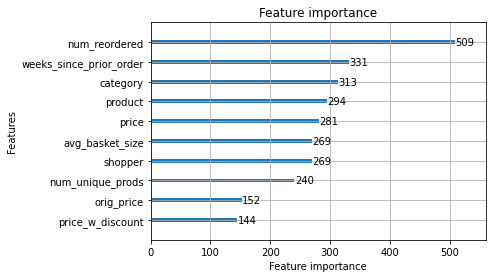

In [75]:
lgb.plot_importance(lgb_clf, max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

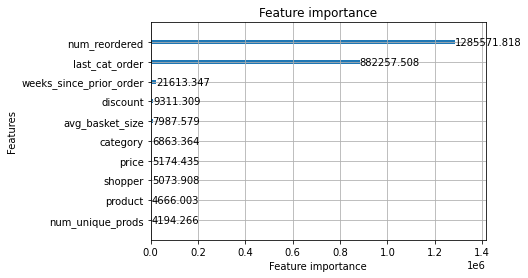

In [76]:
lgb.plot_importance(lgb_clf, max_num_features=10, importance_type='gain')

## Model Assessment - ROC AUC

In [77]:
from sklearn import metrics  # Important lib where we find various performance measures

In [79]:
# metrics.plot_roc_curve(rfc, X_test, y_test)

In [80]:
# metrics.plot_roc_curve(dtc, X_test, y_test)

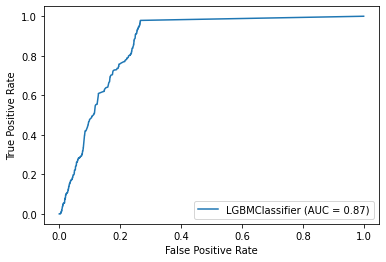

In [82]:
metrics.plot_roc_curve(lgb_clf, X_test, y_test)

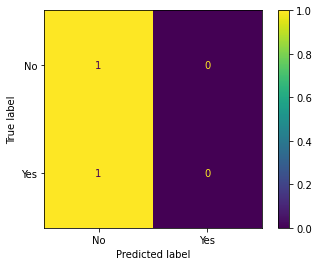

In [83]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = lgb_clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(estimator=lgb_clf, X=X_test, y_true=y_test, display_labels=['No', 'Yes'], normalize='true')

In [84]:
confusion

array([[24286,     0],
       [  714,     0]])

In [85]:
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]
TN = confusion[0][0]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

<ipython-input-85-eccb13aa8264>:11: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP/(TP+FP)
<ipython-input-85-eccb13aa8264>:19: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP/(TP+FP)


In [86]:
print(f'TPR: {TPR:.4f}')
print(f'TNR: {TNR:.4f}')
print(f'FPR: {FPR:.4f}')
print(f'FNR: {FNR:.4f}')
print(f'Precision: {PPV:.4f}')
print(f'False discovery rate: {FDR:.4f}')

TPR: 0.0000
TNR: 1.0000
FPR: 0.0000
FNR: 1.0000
Precision: nan
False discovery rate: nan
